# Long-range erosion and deposition models

This notebook explores erosion and deposition mechanics for long-range transport by rivers. The incision rate in "stream power" form is,

$$
\frac{d h}{d t} = q_s = K q_r^m S^n
$$

where $q_r = \int_0^A R \, \mathrm{d}A$ is the accumulated run-off for all areas which lie upstream, $S$ is the slope, and $K$ is a proportionality constant which relates to the efficiency of the stream to transport sediment. $m$ and $n$ vary depend on the transport theory being used but $\frac{n}{m}=\frac{1}{2}$ is common.

We expore three transport models:

1. Local equilibrium
2. Saltation length (Beaumont _et al._ 1992, Kooi & Beaumont 1994, 1996)
3. $\xi-q$ model (Davy and Lague 2009)

In [1]:
from quagmire import SurfaceProcessMesh
from quagmire import tools as meshtools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,
dx, dy = 0.05, 0.05

x, y, bmask = meshtools.elliptical_mesh(minX, maxX, minY, maxY, dx, dy, 10000, 1000)
x, y = meshtools.lloyd_mesh_improvment(x, y, bmask, 5)
DM = meshtools.create_DMPlex_from_points(x, y, bmask)

height = np.exp(-0.025*(x**2 + y**2)**2) + 0.0001
height += np.random.random(height.size) * 0.05 # random noise
rain   = height**2

sp = SurfaceProcessMesh(DM)
sp.update_height(height)
sp.update_surface_processes(rain, np.zeros_like(rain))

Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0
 - Delaunay triangulation 0.141311s
 - Compute edge lengths 0.019746s
 - Construct neighbour array 0.093048s
 - Find boundaries 0.09195s
 - Build smoothing matrix 0.043165s
 - Sort nodes by field 0.026841s
 - Build downhill matrices 0.120674s
 - Cumulative flow 0.029202s


Each of the erosion-depositon models require the stream power...

In [3]:
def compute_stream_power(self, m=1, n=1):
    """
    Stream power law (q_s)
    """
    rainflux = self.rainfall_pattern
    rainfall = self.area * rainflux
    cumulative_rain = self.cumulative_flow(rainfall)
    cumulative_flow_rate = cumulative_rain / self.area
    stream_power = cumulative_flow_rate**m *self.slope**n
    return stream_power

stream_power = compute_stream_power(sp, m=1, n=1)

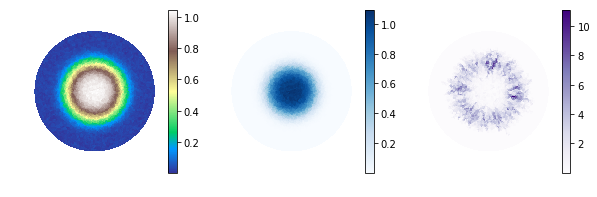

In [4]:
# Plot the height, rainfall, and stream power
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')
im1 = ax1.tripcolor(x, y, sp.tri.simplices, height, cmap='terrain')
im2 = ax2.tripcolor(x, y, sp.tri.simplices, rain, cmap='Blues')
im3 = ax3.tripcolor(x, y, sp.tri.simplices, stream_power, cmap='Purples')

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()

## 1. Local equilibrium

The assumption of the stream power law is that sediment transport is in a state of local equilibrium in which the transport rate is equal to the local carrying capacity. If we neglect suspended-load transport for a moment and assume only bed-load transport then the local deposition is the amount of material that can be eroded from upstream.

In [5]:
def erosion_deposition_1(self, stream_power, efficiency=0.1):
    """
    Local equilibrium model
    """
    erosion_rate = efficiency*stream_power
    full_capacity_sediment_load = stream_power*self.area
    cumulative_eroded_material = self.cumulative_flow(erosion_rate*self.area)
    
    transport_limited_eroded_material = np.minimum(cumulative_eroded_material, full_capacity_sediment_load)
    excess = sp.gvec.duplicate()
    excess.setArray(cumulative_eroded_material - transport_limited_eroded_material)
    
    deposition = excess - self.downhillMat*excess
    deposition_rate = deposition.array/self.area
    return erosion_rate, deposition_rate

erosion_rate1, deposition_rate1 = erosion_deposition_1(sp, stream_power, efficiency=0.1)

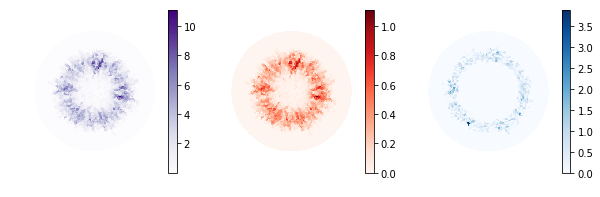

In [6]:
# Plot the stream power, erosion and deposition rates
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')
im1 = ax1.tripcolor(x, y, sp.tri.simplices, stream_power, cmap='Purples')
im2 = ax2.tripcolor(x, y, sp.tri.simplices, erosion_rate1, cmap='Reds', vmin=0)
im3 = ax3.tripcolor(x, y, sp.tri.simplices, deposition_rate1, cmap='Blues', vmin=0)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()

## 2. Saltation length

This model relates the length of time it takes for a grain to settle to a material property, $L_s$.
From Beaumont et al. 1992, Kooi & Beaumont 1994, 1996 we see a linear dependency of deposition flux to stream capacity:

$$
\frac{dh}{dt} = \frac{dq_s}{dl} = \frac{D_c}{q_c} \left(q_c - q_s \right)
$$

where

$$
\frac{D_c}{q_c} = \frac{1}{L_s}
$$

$D_c$ is the detachment capacity, $q_c$ is the carrying capacity, $q_s$ is the stream capacity, and $L_s$ is the erosion length scale (a measure of the detachability of the substrate). When the flux equals capacity, $q_c = q_s$, no erosion is possible.

In [7]:
def erosion_deposition_2(self, stream_power, efficiency=0.1, length_scale=10.):
    """
    Saltation length from Beaumont et al. 1992
    """
    
    erosion_rate = efficiency*stream_power
    
    cumulative_eroded_material = self.cumulative_flow(erosion_rate*self.area)
    cumulative_deposition_rate = cumulative_eroded_material / self.area
    
    erosion_deposition = 1.0/length_scale * (cumulative_deposition_rate - erosion_rate)
    return erosion_rate, erosion_deposition

erosion_rate2, deposition_rate2 = erosion_deposition_2(sp, stream_power, efficiency=0.1, length_scale=10.)

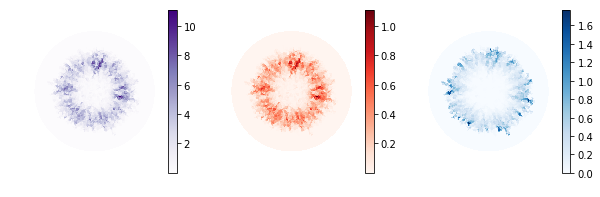

In [8]:
# Plot the stream power, erosion and deposition rates
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')
im1 = ax1.tripcolor(x, y, sp.tri.simplices, stream_power, cmap='Purples')
im2 = ax2.tripcolor(x, y, sp.tri.simplices, erosion_rate2, cmap='Reds')
im3 = ax3.tripcolor(x, y, sp.tri.simplices, deposition_rate2, cmap='Blues')

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()

## 3. $\xi - q$ model

Davy and Lague (2009) propose a similar suspended-load model that encapsulates a range of behaviours between detachment and transport-limited end members. This model couples erodability as a function of stream power with a sedimentation term weighted by $\alpha$.

$$
\frac{dh}{dt} = -K q_r^m S^n + \frac{Q_s}{\alpha Q_w}
$$

where $Q_s$ and $Q_w$ are the sedimentary and water discharge, respectively.

In [9]:
def erosion_depositon_3(self, stream_power, efficiency=0.1, alpha=1.):
    """
    xi - q model from Davy and Lague 2009
    """
    rainflux = self.rainfall_pattern
    rainfall = self.area * rainflux
    cumulative_rain = self.cumulative_flow(rainfall)
    cumulative_flow_rate = cumulative_rain / self.area
    erosion_rate = efficiency*stream_power
    
    cumulative_eroded_material = self.cumulative_flow(erosion_rate*self.area)
    cumulative_deposition_rate = cumulative_eroded_material / self.area
    
    deposition_rate = cumulative_deposition_rate / (alpha * cumulative_flow_rate)

    return erosion_rate, deposition_rate

erosion_rate3, deposition_rate3 = erosion_depositon_3(sp, stream_power, efficiency=0.1, alpha=1.0)

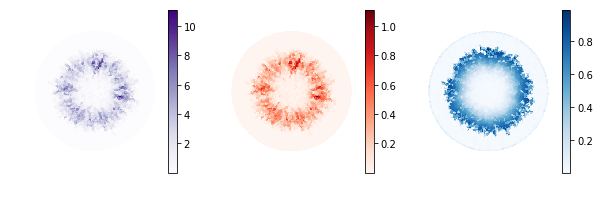

In [10]:
# Plot the stream power, erosion and deposition rates
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')
im1 = ax1.tripcolor(x, y, sp.tri.simplices, stream_power, cmap='Purples')
im2 = ax2.tripcolor(x, y, sp.tri.simplices, erosion_rate3, cmap='Reds')
im3 = ax3.tripcolor(x, y, sp.tri.simplices, deposition_rate3, cmap='Blues')

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()

A comparison of deposition rates calculated from each model...

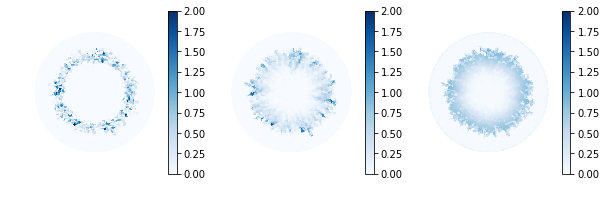

In [11]:
# Compare deposition rates
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')
im1 = ax1.tripcolor(x, y, sp.tri.simplices, deposition_rate1, cmap='Blues', vmin=0, vmax=2)
im2 = ax2.tripcolor(x, y, sp.tri.simplices, deposition_rate2, cmap='Blues', vmin=0, vmax=2)
im3 = ax3.tripcolor(x, y, sp.tri.simplices, deposition_rate3, cmap='Blues', vmin=0, vmax=2)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()